In [1]:
from models.model_pool import GNNModule

from models.sota.kernel_dmv.wrapper import KernelDMV
from models.sota.dares.wrapper import Dares


# Load GNN
CKPT_PTH = "models/saved/final/checkpoints/epoch=99-step=35500.ckpt"
model = GNNModule.load_from_checkpoint(CKPT_PTH)
model.eval()

# Load KDM+V
model_kdm = KernelDMV(x_range=[0,29], y_range=[0,24], cell_size=1, kernel_size=2.5)

# Load DARES
model_dares = Dares()

In [34]:
from data.synthetic import SyntheticDataset
from torch_geometric.loader import DataLoader
# import torch_geometric.transforms as T
# from utils.transforms import Add2DMask, Apply2DMask

dataset = SyntheticDataset(root="data/30x25/", type="test", p_sensor=0.5)
loader = iter(DataLoader(dataset))

Example

RMSE GNN: 0.1263, KLD GNN: 0.1263
RMSE KDM+V: 0.3814, KLD KDM+V: 0.2134
RMSE DARES: 0.6037, KLD DARES: 0.1607


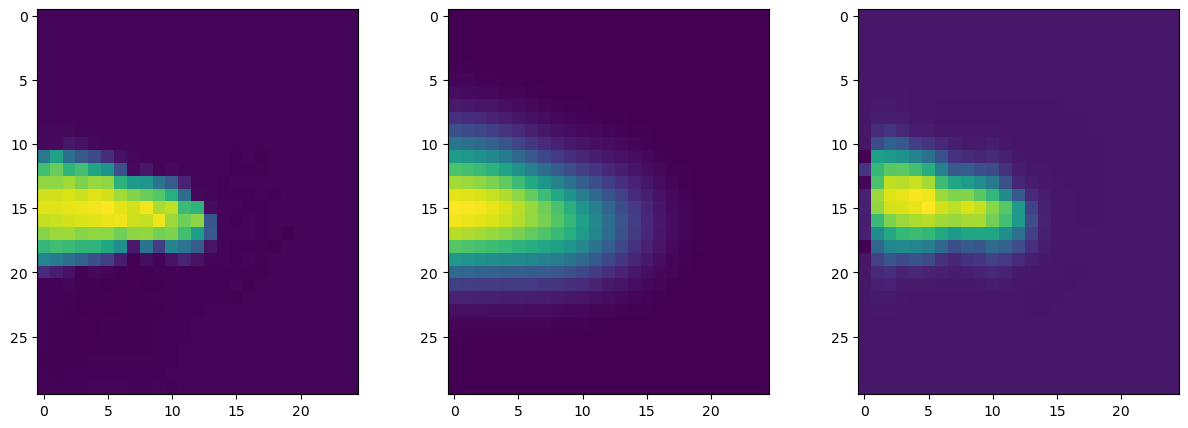

In [41]:
import torch
from utils.mapping import visualize_feature_as_image
import utils.metrics as metrics
import matplotlib.pyplot as plt

data = dataset[13370]
known_mask = data.known[:,-1]
measurements = data.y[known_mask][:,-1]
positions = data.orig_pos[known_mask]


# GNN
with torch.no_grad():
    pred_gnn = model(data.to(model.device))

# KDM+V
model_kdm.set_measurements(positions, measurements)
pred_kdm = model_kdm.predict()

# DARES
model_dares.set_measurements(positions*0.3, measurements)
pred_dares = model_dares.predict()

# plot all three plots in a subplot side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
visualize_feature_as_image(pred_gnn.squeeze(), data.orig_pos, rot_k=0, ax=axs[0])
axs[1].imshow(pred_kdm)

# rotate DARES prediction to match the GNN prediction
pred_dares = torch.rot90(pred_dares, 0, dims=(0,1))
# flip DARES prediction to match the GNN prediction
# pred_dares = torch.flip(pred_dares, dims=(0,))
axs[2].imshow(pred_dares)

rmse_gnn = metrics.rmse(pred_gnn, data.y[:, -1].unsqueeze(1))
kld_gnn = metrics.rmse(pred_gnn, data.y[:, -1].unsqueeze(1))

data.to('cpu')

rmse_kdm = metrics.rmse(pred_kdm, data.y[:, -1].reshape(30, 25))
kld_kdm = metrics.kld(pred_kdm, data.y[:, -1].reshape(30, 25))

rmse_dares = metrics.rmse(pred_dares, data.y[:, -1].reshape(30, 25))
kld_dares = metrics.kld(pred_dares, data.y[:, -1].reshape(30, 25))

print(f"RMSE GNN: {rmse_gnn:.4f}, KLD GNN: {kld_gnn:.4f}")
print(f"RMSE KDM+V: {rmse_kdm:.4f}, KLD KDM+V: {kld_kdm:.4f}")
print(f"RMSE DARES: {rmse_dares:.4f}, KLD DARES: {kld_dares:.4f}")

In [48]:
i = 1000
data = dataset[i]
known_mask = data.known[:,-1]
measurements = data.y[known_mask][:,-1]
positions = data.orig_pos[known_mask]


model_dares.set_measurements(positions, measurements)
pred_dares = model_dares.predict()

# rotate DARES prediction to match the GNN prediction
pred_dares = torch.rot90(torch.tensor(pred_dares), 0, dims=(0,1))
# flip DARES prediction to match the GNN prediction
# pred_dares = torch.flip(pred_dares, dims=(0,))

rmse_dares = metrics.rmse(pred_dares, data.y[:, -1].reshape(30, 25).to('cpu'))
# rmse_dares_values.append(rmse_dares.item())

kld_dares = metrics.kld(pred_dares, data.y[:, -1].reshape(30, 25).to('cpu'))
# kld_dares_values.append(kld_dares.item())

/tmp/ipykernel_2580617/3913717191.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_dares = torch.rot90(torch.tensor(pred_dares), 0, dims=(0,1))


In [47]:
pred_dares.shape

torch.Size([25, 30])

In [50]:
from tqdm import tqdm
import datetime

import utils.metrics as metrics
from models.model_pool import GNNModule
from models.sota.kernel_dmv.wrapper import KernelDMV
from models.sota.dares.wrapper import Dares

from data.synthetic import SyntheticDataset

CALC_GNN = True
CALC_KDM = True
CALC_DARES = True

# Metrics storage
rmse_gnn_values = []
rmse_gnntv_values = []
rmse_kdm_values = []
rmse_dares_values = []

kld_gnn_values = []
kld_gnntv_values = []
kld_kdm_values = []
kld_dares_values = []

#~~~~~~~~
#~ DATA ~
#~~~~~~~~

percentage = 0.08

dataset = SyntheticDataset(root="data/30x25/", type="test", p_sensor=percentage)

#~~~~~~~~~~
#~ MODELS ~
#~~~~~~~~~~

# Load GNN
CKPT_PTH = "models/saved/final/checkpoints/epoch=99-step=35500.ckpt"
model = GNNModule.load_from_checkpoint(CKPT_PTH)
model.eval()

# Load KDM+V
model_kdm = KernelDMV(x_range=[0,29], y_range=[0,24], cell_size=1, kernel_size=2.5)

# Load DARES
model_dares = Dares()

#~~~~~~~~
#~ LOOP ~
#~~~~~~~~

# Process samples in dataset
n_samples = len(dataset)
for i in tqdm(range(n_samples)):
    data = dataset[i]
    known_mask = data.known[:,-1]
    measurements = data.y[known_mask][:,-1]
    positions = data.orig_pos[known_mask]

    if CALC_GNN:
        pred = model(data.to(model.device))

        rmse_gnn = metrics.rmse(pred, data.y[:, -1].unsqueeze(1))
        rmse_gnn_values.append(rmse_gnn.item())

        kld_gnn = metrics.kld(pred, data.y[:, -1].unsqueeze(1))
        kld_gnn_values.append(kld_gnn.item())

    if CALC_KDM:
        model_kdm.set_measurements(positions, measurements)
        pred_kdm = model_kdm.predict()

        rmse_kdm = metrics.rmse(pred_kdm, data.y[:, -1].reshape(30, 25).to('cpu'))
        rmse_kdm_values.append(rmse_kdm.item())

        kld_kdm = metrics.kld(pred_kdm, data.y[:, -1].reshape(30, 25).to('cpu'))
        kld_kdm_values.append(kld_kdm.item())

    if CALC_DARES:
        model_dares.set_measurements(positions, measurements)
        pred_dares = model_dares.predict()

        # rotate DARES prediction to match the GNN prediction
        pred_dares = torch.rot90(pred_dares, 0, dims=(0,1))

        rmse_dares = metrics.rmse(pred_dares, data.y[:, -1].reshape(30, 25).to('cpu'))
        rmse_dares_values.append(rmse_dares.item())

        kld_dares = metrics.kld(pred_dares, data.y[:, -1].reshape(30, 25).to('cpu'))
        kld_dares_values.append(kld_dares.item())

#~~~~~~~
#~ LOG ~
#~~~~~~~
# add current data in file name
file_name = "metrics_synthetic_" + str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")) + ".txt"

with open(f"test_logs/{file_name}", "w+") as f:
    f.write(f"Random Percentage: {percentage} \n")
    if CALC_GNN:
        f.write("Mean RMSE for GNN: " + str(sum(rmse_gnn_values) / len(rmse_gnn_values)) + "\n")
        f.write("Mean KLD for GNN: " + str(sum(kld_gnn_values) / len(kld_gnn_values)) + "\n")
    if CALC_KDM:
        f.write("Mean RMSE for KDM: " + str(sum(rmse_kdm_values) / len(rmse_kdm_values)) + "\n")
        f.write("Mean KLD for KDM: " + str(sum(kld_kdm_values) / len(kld_kdm_values)) + "\n")
    if CALC_DARES:
        f.write("Mean RMSE for DARES: " + str(sum(rmse_dares_values) / len(rmse_dares_values)) + "\n")
        f.write("Mean KLD for DARES: " + str(sum(kld_dares_values) / len(kld_dares_values)) + "\n")

100%|██████████| 23760/23760 [23:23<00:00, 16.93it/s] 
